# Determining the proton content with a quantum computer

Code at: https://github.com/Quantum-TII/qibo/tree/master/examples/qPDF.

In this tutorial we show how to use the `qPDF` model implemented in Qibo to create a set of Parton Distribution Functions (PDFs), parameterized by a variational quantum circuit. In the context of High Energy Physics, parton distribution functions estimate the momentum fraction of the proton carried by partons i.e. quarks, antiquarks and gluon. Here we simulate a quantum computer to encode within a circuit the data from these PDFs in such a way that, if we measure the output of the aforementioned quantum circuit, we obtain the corresponding PDFs values.

In order to accomplish our goal, we use a Variational Quantum Circuit (VQC): 

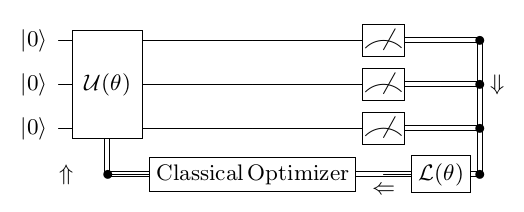

### Circuit

We consider two different Ansätze. Those Ansätze depend on tunable parameters and a variable $x$ that also serves as the independent variables for the PDF $f_i(x, Q)$, where $Q$ is fixed. 

The first one is the Ansatz _Weighted_. Its basic single qubit gate is 

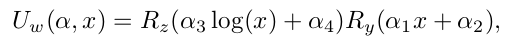

The second Ansatz is the fourier one, whose basic single-qubit gate is, on demand

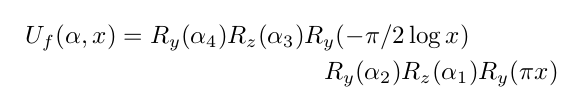

Both Ansätze have a layered structure with entangling gates among different qubits depicted in the following circuit

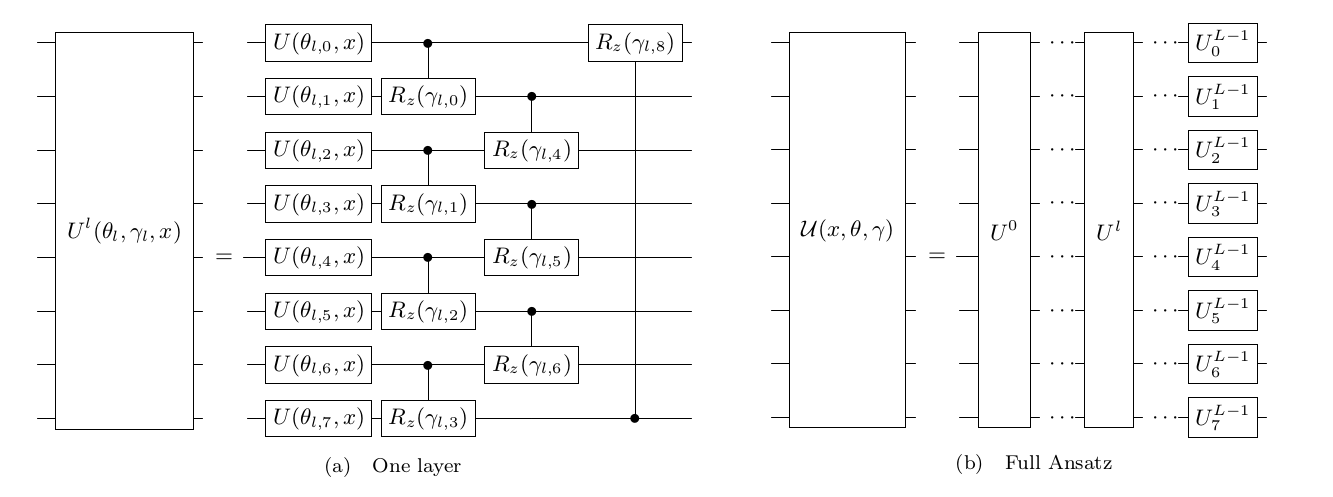

The Ansatz is constructed in one qubit per parton. We only let one and all flavours $(s, \bar s, c, u, \bar u, d, \bar d, g)$ to be optimized simultaneously, thus only circuits with one and eight qubits are available.

### Cost function

The cost function driving the optimization process of this circuit is defined through several pieces. First, we need a Hamiltonian to measure. We choose a different hamiltonian for every parton, namely 

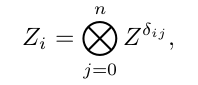

This family of hamiltonians allows for the definition of their expected values, depending on $\theta$ and $x$

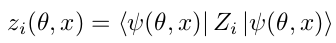

The relation between the $z(\theta, x)$ quantities and PDFs is

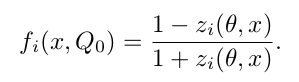

Using this definition, we can just use the usual Pearson's chi-squared quantity

$$
\chi^2 = \frac{1}{N}\sum_{i=1}^N \int_{x\in[0, 1]} dx \frac{\left( f_i (x, \theta) - \frac{1 - z(x, \theta)}{1 + z(x, \theta)}\right)^2}{\sigma^2}
$$

This is the loss function for our minimization procedure.

## Code

First, we must decide the variables for our problem. The meaning of them are
- `ansatz`: Which one is chosen, *Weighted* or *Fourier*.
- `multi_output`: If *True*, all partons are fitted in the same circuit.
- `parton`: which parton is to be fit. Ignored if `multi_output = True`.
- `mode`: if *full*, data is fitted for $x \in [10^{-4}, 1]$, if *partial* only large $x$ is considered.
- `layers`: number of layers.

### Create a qPDF model

In [1]:
# import requirements
import numpy as np
from qibo.hep import qPDF

# our setup
ansatz = 'Weighted'
multi_output = True
parton = '8flavours' # or gluon
mode = 'full' # or partial
layers = 3

Extract reference data and auxiliary variables. These cell controls the importing of different sets of data.

In [2]:
# Read input data
def load_data_and_setup():
    if multi_output:
        data_file = f'data/{mode}/8flavours.dat'
        nqubits = 8
    else:
        data_file = f'data/{mode}/{parton}.dat'
        nqubits = 1    
    return np.loadtxt(data_file), nqubits

# load data
data, nqubits = load_data_and_setup()

# load qPDF model
mypdf = qPDF(ansatz, layers, nqubits, multi_output=multi_output)

Now we define a way to compute the loss function 

$$
\chi^2 = \frac{1}{N}\sum_{i=1}^N\sum_{j} \frac{\left( f_i (x_j, \theta) - \frac{1 - z(x_j, \theta)}{1 + z(x_j, \theta)}\right)^2}{\sigma^2}
$$

is defined. For multi-flavour fits, a mean is considered.

In [3]:
# Define loss function
def loss(params):
    """Compute loss for a given set of parameters.

    Args:
        parameters (np.array): the list of parameters for the gates.

    Returns:
        The loss function.
    """
    xtrain = data[:, 0]
    if multi_output:
        cf = 0
        i = 1
        for ypred in mypdf.predict(params, xtrain).transpose():
            ytrain = data[:, i]
            ysigma = data[:, i + 1]
            cf += np.mean(np.square(ytrain - ypred) / ysigma ** 2)
            i += 2
        cf /= 8
    else:
        ytrain = data[:, 1]
        ysigma = data[:, 2]
        ypred = mypdf.predict(params, xtrain).flatten()
        cf = np.mean(np.square(ytrain - ypred) / ysigma ** 2)
    return cf

Optimization procedure extracted from standard techniques must be used to look for the optimal configuration of $\theta$ parameters. In this case, we will implement optimizers from `scipy` and a genetic one.


```python
# Optimizing
from qibo.optimizers import optimize

np.random.seed(10)
params = np.random.rand(mypdf.nparams)
_, params = optimize(loss, params, method='cma')
```

The optimization may be costly in some cases. In order to save time, we provide some precomputed results that will let you to see the performance of this algorithm in several circumstances. Precomputed results include the ones detailed in the corresponding paper.

In [4]:
# For taking old results
import pickle
with open(f'results/{mode}/{parton}/{ansatz}_{nqubits}_q_{layers}_l_result.pkl', 'rb') as f:
    results = pickle.load(f)
    
params = results['x']

Let us now take a look at the results! These graphs compare the reference data (black) and the current optimized fit (blue).

In [5]:
# Auxiliary plotting function
import matplotlib.pyplot as plt

def plot_PDF(params, chi2):
    if multi_output:
        fig, axs = plt.subplots(2, 4, figsize=(13, 9), sharex=True, sharey=True)
        i = 1
        partons = ['sbar', 'ubar', 'dbar', 'gluon', 'd', 'u', 's', 'c']
        partons_name = [r'$\bar s$', r'$\bar u$', r'$\bar d$', r'$g$', r'$d$', r'$u$', r'$s$', r'$c$']
        xtrain = data[:, 0]
        for ax, yprediction in zip(axs.flatten(), mypdf.predict(params, xtrain).transpose()):
            ytrain = data[:, i].copy()
            ysigma = data[:, i + 1].copy()
            if i == 7:
                ax.set(title=partons_name[(i - 1) // 2] + ' / 3', xscale='log')
                yprediction /= 3
                ytrain /= 3
                ysigma /= 3
            elif i == 15:
                ax.set(title=partons_name[(i - 1) // 2] + r' $\times$ 10', xscale='log')
                yprediction *= 10
                ytrain *= 10
                ysigma *= 10
            else:
                ax.set(title=partons_name[(i - 1) // 2], xscale='log')
            if (i - 1) // 2 % 4 == 0:
                ax.set(ylabel='PDF')
            if (i - 1) // 2 > 3:
                ax.set(xlabel='x')

            ax.plot(xtrain, ytrain, label='Classical PDF', color='black')
            ax.fill_between(xtrain, ytrain + ysigma, ytrain - ysigma, alpha=0.3, color='black')
            ax.plot(xtrain, yprediction.flatten(), label=r'qPDF model', color='orange', linewidth=2, zorder=10)
            ax.set(ylim=[-0.05, 1])
            i += 2
            ax.grid(True)
        fig.suptitle(f'$\chi^2 = $ {chi2:.4f}')
        plt.legend()
    else:
        fig, ax = plt.subplots(figsize = (8, 6))
        ax.set(title=f'$\chi^2 = $ {chi2:.2f}', xlabel='x', ylabel='PDF',
               xscale='log')
        xtrain = data[:, 0]
        ytrain = data[:, 1]
        ysigma = data[:, 2]
        yprediction = mypdf.predict(params, xtrain).flatten()
        ax.plot(xtrain, ytrain, label='Classical '+ parton + ' PDF', color='black')
        ax.fill_between(xtrain, ytrain + ysigma, ytrain - ysigma, alpha=0.3, color='black')
        ax.plot(xtrain, yprediction.flatten(), label=r'Quantum PDF model', zorder=10)
        ax.legend()

## Plot results

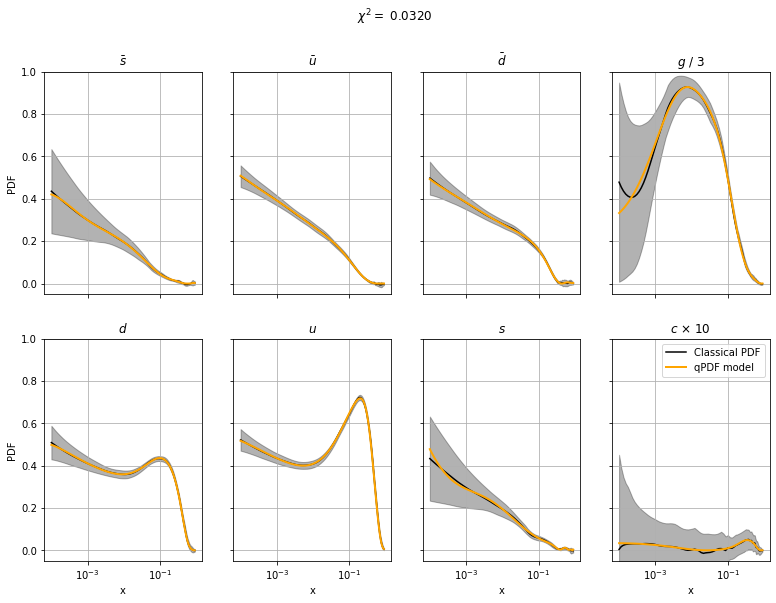

In [6]:
plot_PDF(params, chi2=loss(params))